In [2]:
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.signal import chirp, butter, filtfilt,correlate
from gtda.time_series import SingleTakensEmbedding, takens_embedding_optimal_parameters
from sklearn.neighbors import NearestNeighbors
from gtda.plotting import plot_point_cloud
import csv
import pandas as pd 
import plotly.graph_objects as go
from nolitsa import dimension, delay
from sklearn.decomposition import PCA
import gudhi as gd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import kmapper as km
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

In [3]:


# Parámetros de la señal y el ruido
sample_rate = 2048 # Hz
signal_duration = 2 # segundos
noise_duration = 0.976 # segundos
num_signals = 1500
mass_ratio_min = 1.0078
mass_ratio_max = 9.9759
R_min = 0.075
R_max = 0.65

In [4]:
# Generar señales de referencia
mass_ratios = np.random.uniform(mass_ratio_min, mass_ratio_max, num_signals)
reference_signals = []
for mass_ratio in mass_ratios:
    time = np.linspace(0, signal_duration, int(sample_rate * signal_duration), endpoint=False)
    signal = chirp(time, f0=10, f1=100, t1=signal_duration, method='linear')
    reference_signals.append(signal)

# Función para insertar señal en ruido
def insert_signal_in_noise(signal, noise_duration):
    noise = np.random.normal(0, 0.5, int(sample_rate * noise_duration)) # Generar ruido
    start_time = random.uniform(0, noise_duration) # Tiempo de inicio aleatorio dentro del ruido
    end_time = start_time + signal_duration # Tiempo de finalización de la señal en el ruido
    full_signal = np.concatenate([noise[:int(start_time * sample_rate)], signal, noise[int(end_time * sample_rate):]])
    return full_signal, start_time

# Generar conjunto de entrenamiento
training_data = []
for signal in reference_signals:
    R = np.random.uniform(R_min, R_max) # Coeficiente R aleatorio
    presence = random.random() < 0.5 # Probabilidad del 50% de presencia de la señal
    if presence:
        signal_in_noise, start_time = insert_signal_in_noise(signal, noise_duration)
        training_data.append((signal_in_noise, R, start_time))


In [5]:
# Definir las funciones para el filtrado
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

# Parámetros del filtro
cutoff_frequency = 50.0  # Frecuencia de corte del filtro
order = 5  # Orden del filtro

# Filtrar y visualizar una señal de ejemplo
signal_data = training_data[0][0]
R_value = training_data[0][1]
start_time = training_data[0][2]

# Tiempo para la señal
time = np.arange(0, len(signal_data)/sample_rate, 1/sample_rate)

# Filtrar la señal
filtered_signal = lowpass_filter(signal_data, cutoff_frequency, sample_rate, order)


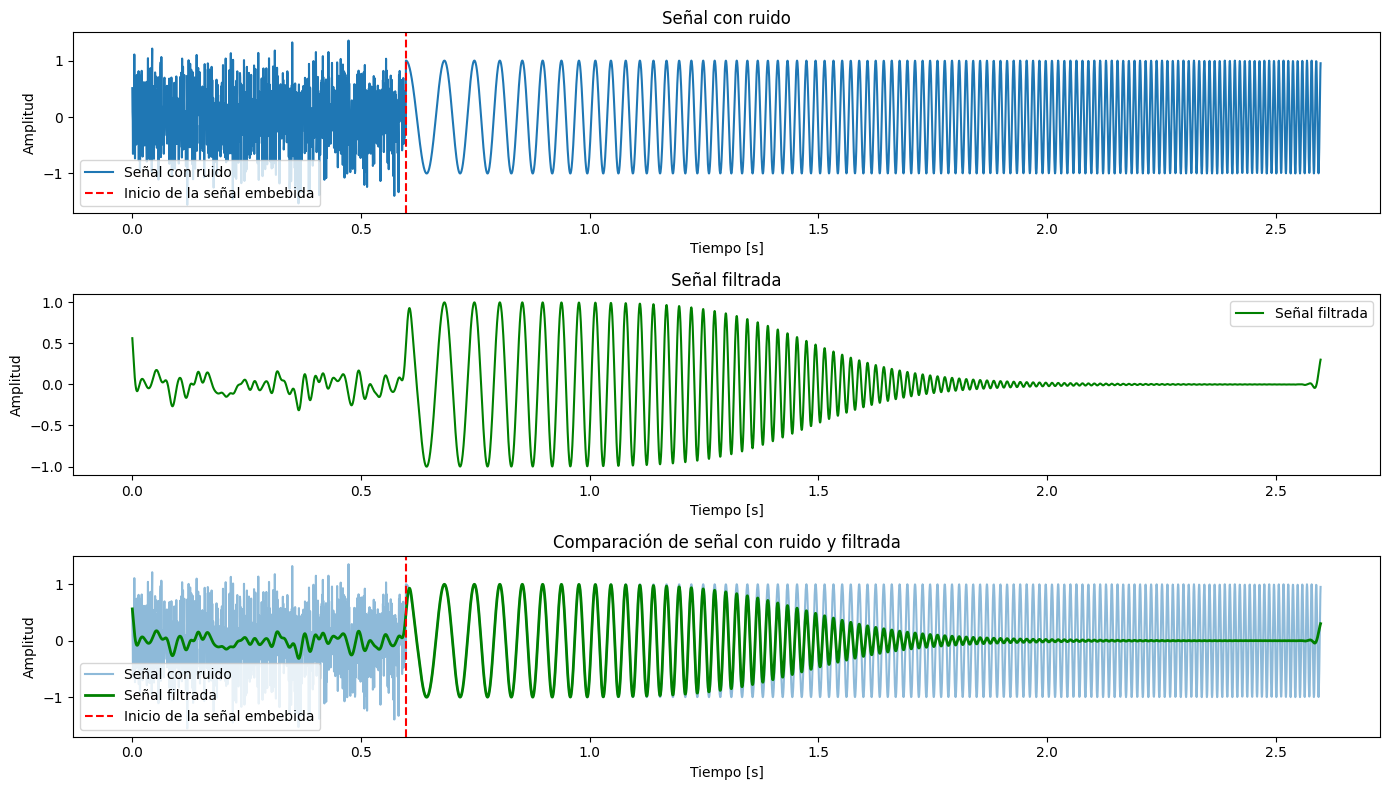

In [6]:
# Graficar la señal original y filtrada
plt.figure(figsize=(14, 8))

plt.subplot(3, 1, 1)
plt.plot(time, signal_data, label='Señal con ruido')
plt.axvline(start_time, color='red', linestyle='--', label='Inicio de la señal embebida')
plt.title('Señal con ruido')
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(time, filtered_signal, label='Señal filtrada', color='green')
plt.title('Señal filtrada')
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(time, signal_data, label='Señal con ruido', alpha=0.5)
plt.plot(time, filtered_signal, label='Señal filtrada', color='green', linewidth=2)
plt.axvline(start_time, color='red', linestyle='--', label='Inicio de la señal embebida')
plt.title('Comparación de señal con ruido y filtrada')
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud')
plt.legend()

plt.tight_layout()
plt.show()


In [7]:
max_embedding_time_delay = 3
max_embedding_dimension = 2


# Encajar la señal de ruido
embedder = SingleTakensEmbedding(
    parameters_type="search",
    n_jobs=-1,  # Usar todos los núcleos disponibles
    time_delay=max_embedding_time_delay,
    dimension=max_embedding_dimension,
    stride=1
)
embedded_noise = embedder.fit_transform(signal_data)

# Encajar la señal filtrada
embedded_filtered_signal = embedder.fit_transform(filtered_signal)

embedded_noise



array([[ 0.51250471, -0.65259274],
       [ 0.09146265,  0.30733657],
       [-0.06359798,  0.44115762],
       ...,
       [-0.26554311,  0.60575243],
       [ 0.03764928,  0.81766244],
       [ 0.33739757,  0.95331622]])

In [8]:
embedded_filtered_signal

array([[0.56360565, 0.42430766],
       [0.51817575, 0.37697941],
       [0.47155712, 0.33010868],
       ...,
       [0.22305718, 0.27405378],
       [0.2410628 , 0.2886932 ],
       [0.25812443, 0.30192167]])

In [9]:
embedded_noise==embedded_filtered_signal

array([[False, False],
       [False, False],
       [False, False],
       ...,
       [False, False],
       [False, False],
       [False, False]])

In [10]:
plot_point_cloud(embedded_noise)

In [11]:
plot_point_cloud(embedded_filtered_signal)

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

# Crear DataFrames para señales embebidas
df_embedded_noise = pd.DataFrame(embedded_noise, columns=[f'Dim_{i+1}' for i in range(embedded_noise.shape[1])])
df_embedded_filtered = pd.DataFrame(embedded_filtered_signal, columns=[f'Dim_{i+1}' for i in range(embedded_filtered_signal.shape[1])])

# Añadir etiquetas
df_embedded_noise['Type'] = 'Noise'
df_embedded_filtered['Type'] = 'Filtered'
df_combined = pd.concat([df_embedded_noise, df_embedded_filtered])
df_combined.head()


,Dim_1,Dim_2,Type
0,0.512505,-0.652593,Noise
1,0.091463,0.307337,Noise
2,-0.063598,0.441158,Noise
3,-0.652593,-0.102302,Noise
4,0.307337,0.294793,Noise


# ANÁLISIS DESCRIPTIVO

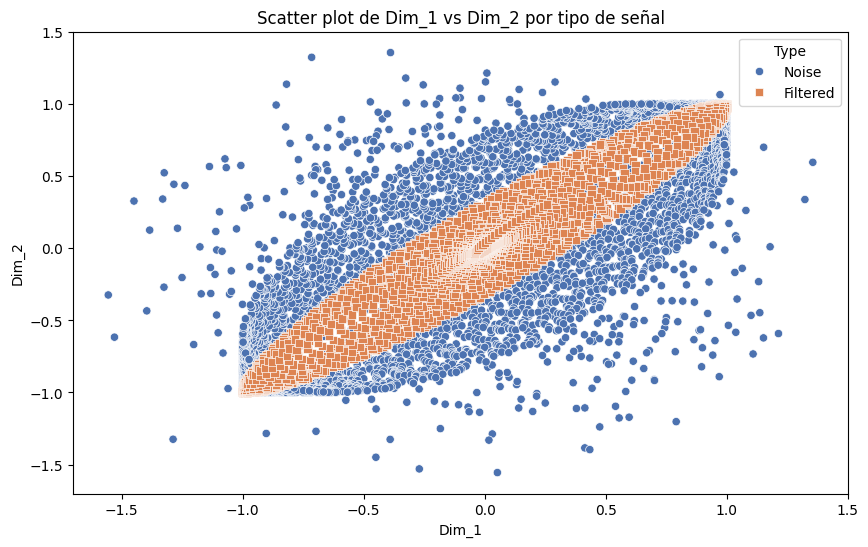

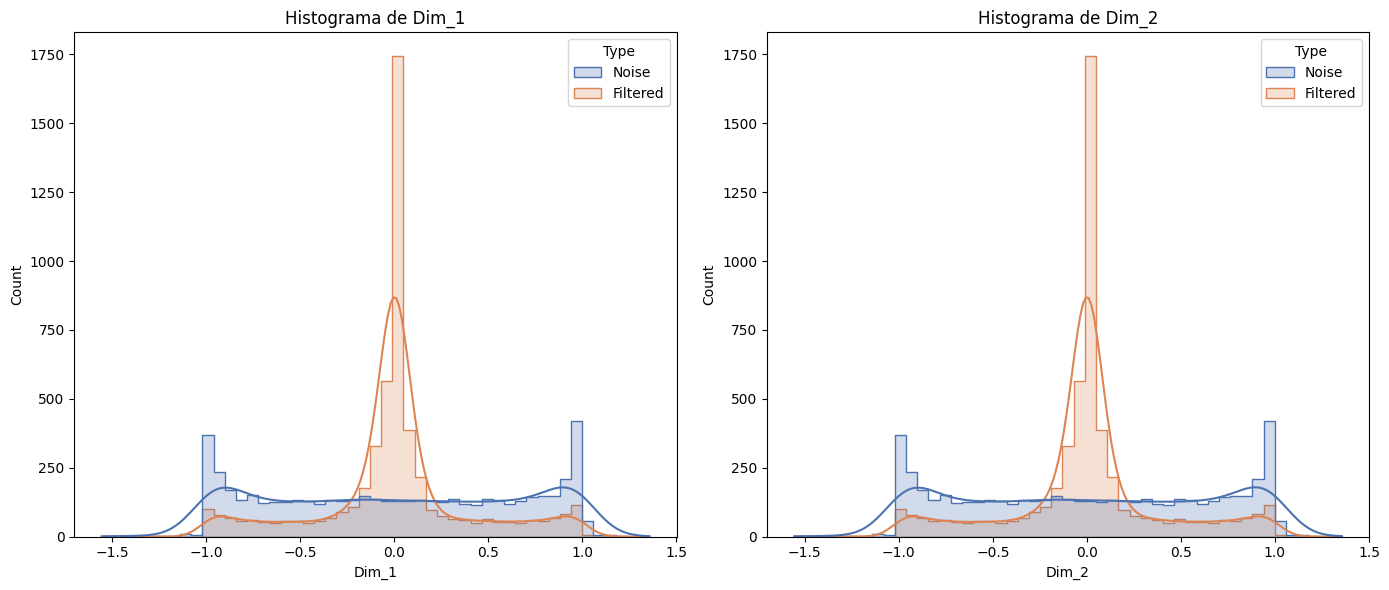

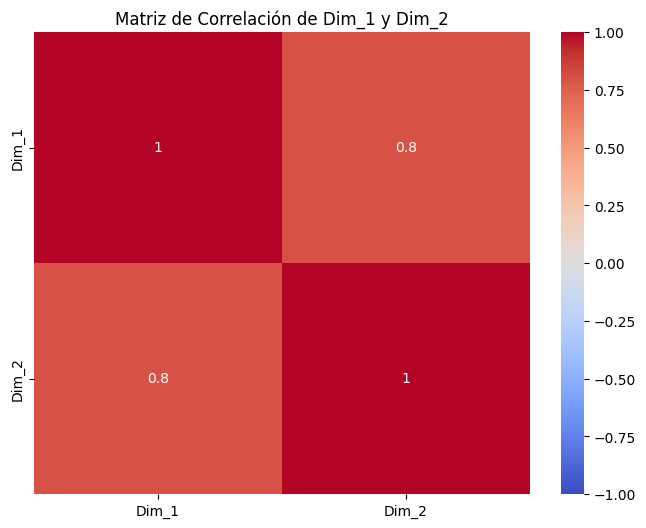

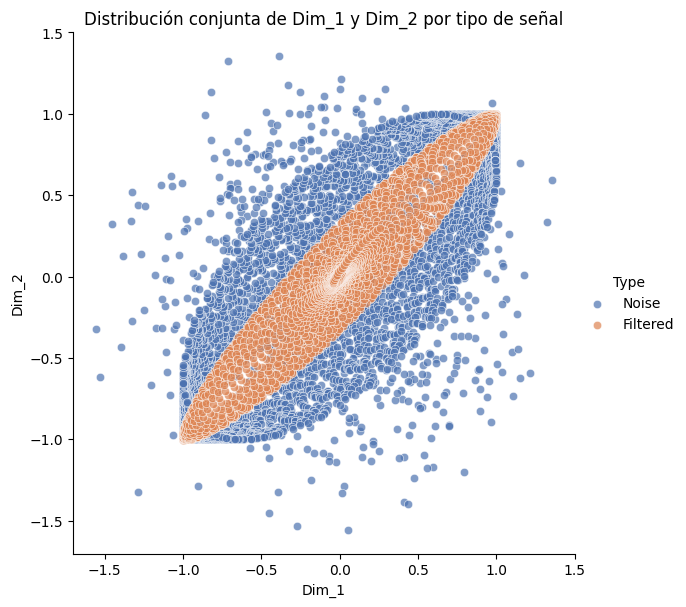

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Crear DataFrames para señales embebidas
df_embedded_noise = pd.DataFrame(embedded_noise, columns=[f'Dim_{i+1}' for i in range(embedded_noise.shape[1])])
df_embedded_filtered = pd.DataFrame(embedded_filtered_signal, columns=[f'Dim_{i+1}' for i in range(embedded_filtered_signal.shape[1])])

# Añadir etiquetas
df_embedded_noise['Type'] = 'Noise'
df_embedded_filtered['Type'] = 'Filtered'
df_combined = pd.concat([df_embedded_noise, df_embedded_filtered])

# Scatter plot para visualizar Dim_1 vs Dim_2
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_combined, x='Dim_1', y='Dim_2', hue='Type', style='Type', markers=["o", "s"], palette='deep')
plt.title('Scatter plot de Dim_1 vs Dim_2 por tipo de señal')
plt.show()

# Histograma para Dim_1 y Dim_2 por tipo de señal
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(data=df_combined, x='Dim_1', hue='Type', element='step', kde=True, palette='deep')
plt.title('Histograma de Dim_1')

plt.subplot(1, 2, 2)
sns.histplot(data=df_combined, x='Dim_2', hue='Type', element='step', kde=True, palette='deep')
plt.title('Histograma de Dim_2')

plt.tight_layout()
plt.show()

# Matriz de correlación
correlation_matrix = df_combined.drop(columns='Type').corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Matriz de Correlación de Dim_1 y Dim_2')
plt.show()

# Distribución conjunta para cada tipo de señal
g = sns.FacetGrid(df_combined, hue='Type', palette='deep', height=6)
g.map(sns.scatterplot, 'Dim_1', 'Dim_2', alpha=0.7)
g.add_legend()
plt.title('Distribución conjunta de Dim_1 y Dim_2 por tipo de señal')
plt.show()


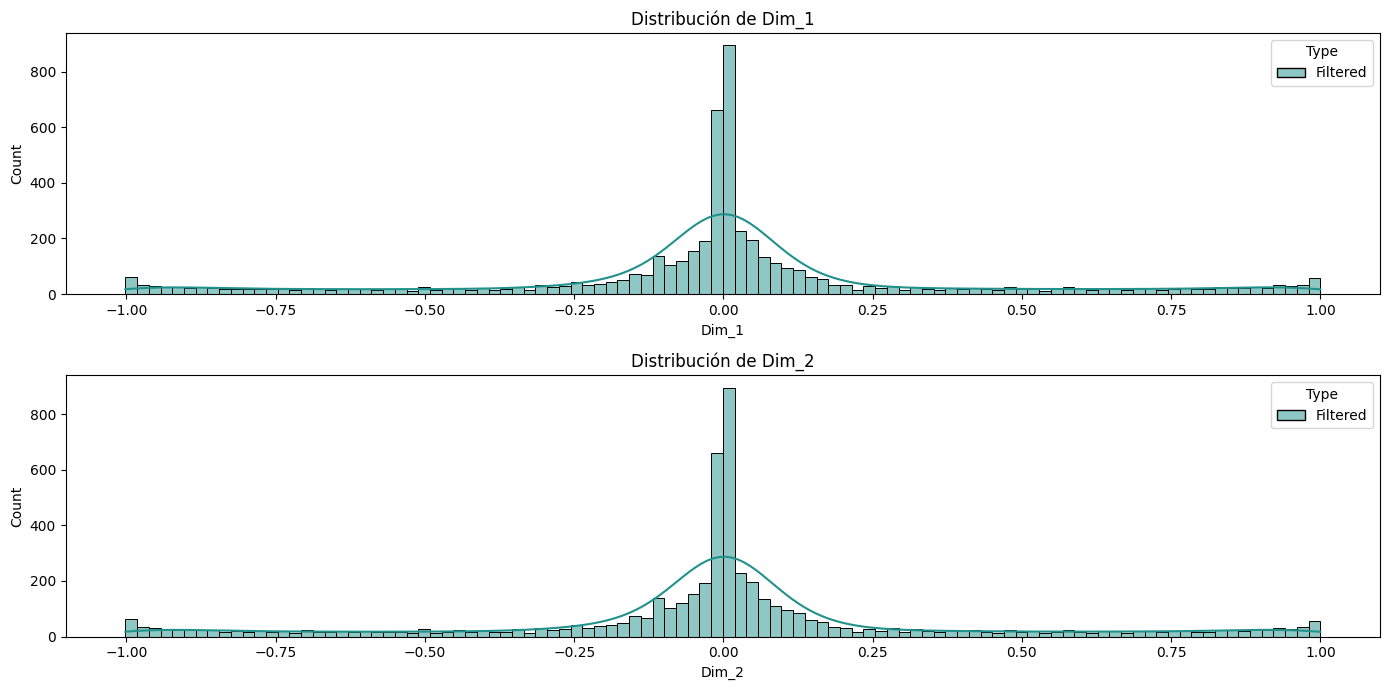

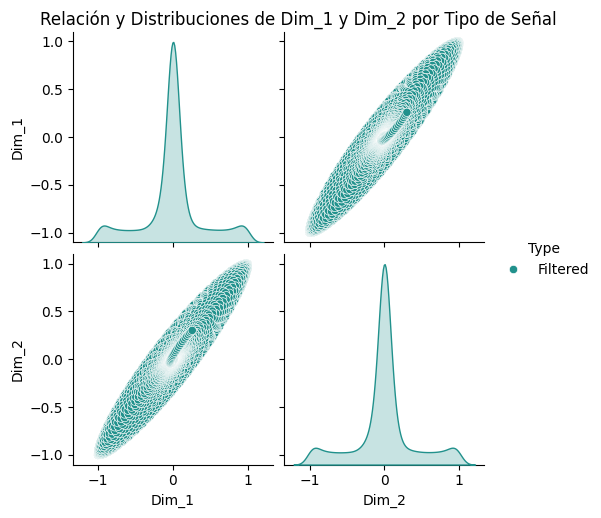

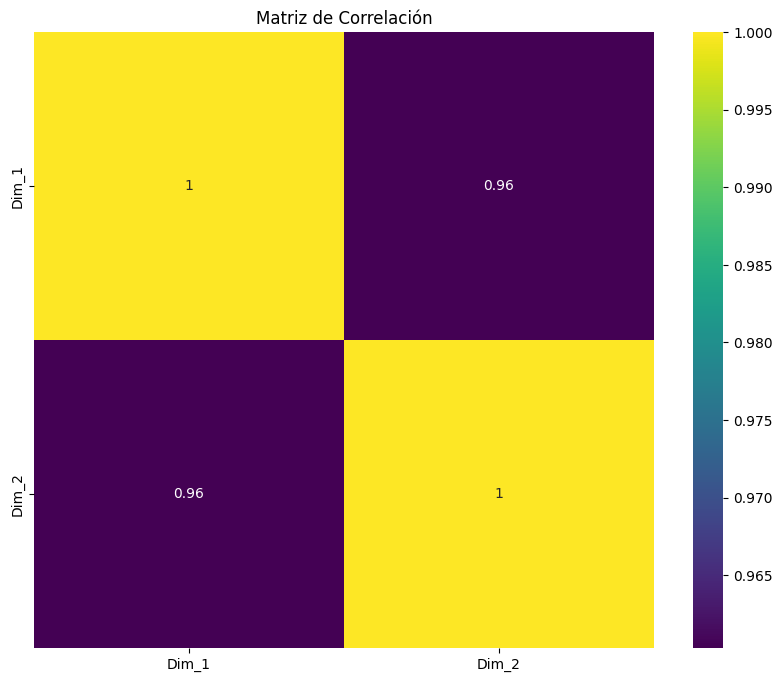

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

# Crear DataFrames para señales embebidas
df_embedded_noise = pd.DataFrame(embedded_noise, columns=[f'Dim_{i+1}' for i in range(embedded_noise.shape[1])])
df_embedded_filtered = pd.DataFrame(embedded_filtered_signal, columns=[f'Dim_{i+1}' for i in range(embedded_filtered_signal.shape[1])])

# Añadir etiquetas
df_embedded_noise['Type'] = 'Noise'
df_embedded_filtered['Type'] = 'Filtered'
df_combined = pd.concat([df_embedded_noise, df_embedded_filtered])

# Eliminar filas con valores nulos en las columnas de dimensiones
df_combined_filtered = df_combined[df_combined['Type'] != 'Noise']

# Distribuciones de Frecuencia
plt.figure(figsize=(14, 7))
for i, column in enumerate(df_combined_filtered.columns[:-1]):
    plt.subplot(2, (df_combined_filtered.shape[1]-1)//2, i+1)
    sns.histplot(data=df_combined_filtered, x=column, hue='Type', kde=True, palette='viridis')
    plt.title(f'Distribución de {column}')
plt.tight_layout()
plt.show()

# Gráfica combinada de ambas dimensiones y distribuciones
sns.pairplot(df_combined_filtered, hue='Type', palette='viridis', diag_kind='kde')
plt.suptitle('Relación y Distribuciones de Dim_1 y Dim_2 por Tipo de Señal', y=1.02)
plt.show()

# Matriz de Correlación
correlation_matrix = df_combined_filtered.drop('Type', axis=1).corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='viridis')
plt.title('Matriz de Correlación')
plt.show()

# ANÁLISIS INFERENCIAL

In [15]:
from scipy.stats import ttest_ind

# Pruebas t de las dimensiones embebidas
p_values = {}
for column in df_combined.columns[:-1]:
    noise_data = df_embedded_noise[column]
    filtered_data = df_embedded_filtered[column]
    t_stat, p_val = ttest_ind(noise_data, filtered_data)
    p_values[column] = p_val

# Mostrar resultados de las pruebas de hipótesis
for dim, p_val in p_values.items():
    print(f'P-valor para {dim}: {p_val}')
    


P-valor para Dim_1: 0.9090388399368847
P-valor para Dim_2: 0.9446169535400052


# ANÁLISIS EXPLORATORIO

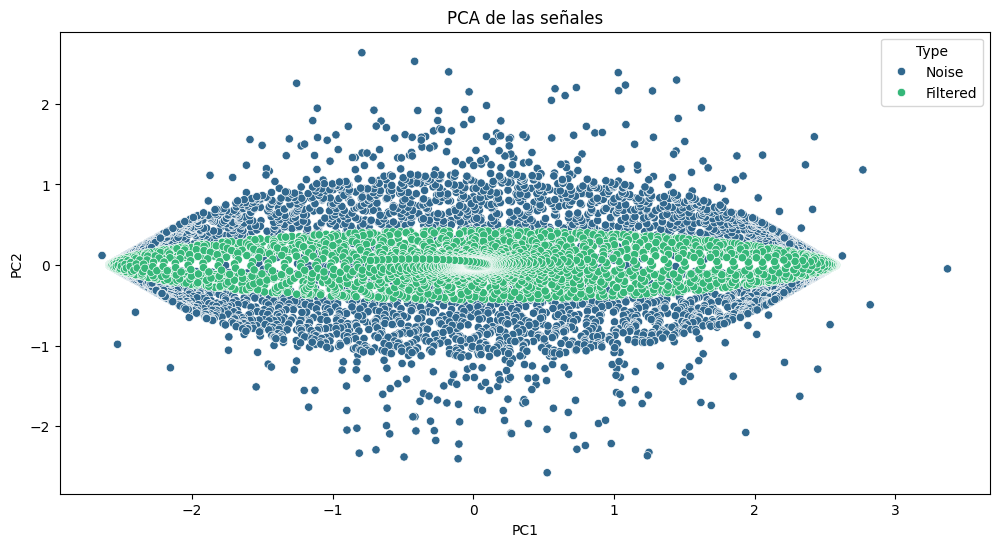

In [16]:
from sklearn.decomposition import PCA

# Estandarización de los datos
scaler = StandardScaler()
df_combined_scaled = scaler.fit_transform(df_combined.drop('Type', axis=1))

# Análisis PCA
pca = PCA(n_components=2)
pca_combined = pca.fit_transform(df_combined_scaled)
df_pca_combined = pd.DataFrame(data=pca_combined, columns=['PC1', 'PC2'])
df_pca_combined['Type'] = df_combined['Type'].values

# Visualización PCA
plt.figure(figsize=(12, 6))
sns.scatterplot(x='PC1', y='PC2', hue='Type', data=df_pca_combined, palette='viridis')
plt.title('PCA de las señales')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()


# ANÁLISIS PREDICTIVO

# USANDO RANDOM FOREST

Random Forest Classification Report:
[[1235  381]
 [ 375 1200]]
              precision    recall  f1-score   support

           0       0.77      0.76      0.77      1616
           1       0.76      0.76      0.76      1575

    accuracy                           0.76      3191
   macro avg       0.76      0.76      0.76      3191
weighted avg       0.76      0.76      0.76      3191



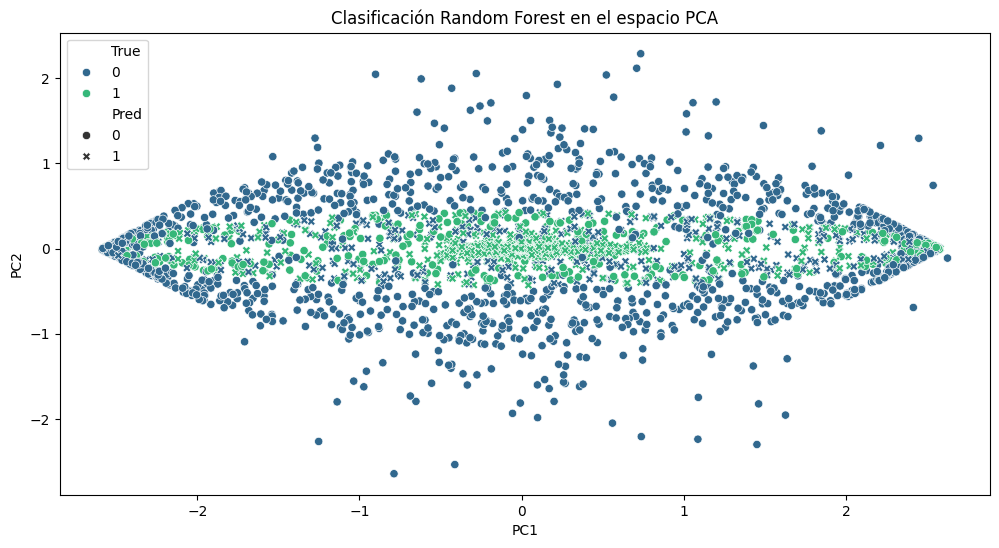

In [17]:


# Preparación de los datos
X = df_combined_scaled
y = df_combined['Type'].apply(lambda x: 1 if x == 'Filtered' else 0)  # Convertir las etiquetas a 0 y 1

# División de los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predicción y evaluación para Random Forest
y_pred_rf = rf_model.predict(X_test)
print("Random Forest Classification Report:")
print(confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

# Visualización del modelo Random Forest en el espacio PCA
pca_rf = PCA(n_components=2)
X_pca_train_rf = pca_rf.fit_transform(X_train)
X_pca_test_rf = pca_rf.transform(X_test)

rf_model_pca = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model_pca.fit(X_pca_train_rf, y_train)
y_pred_pca_rf = rf_model_pca.predict(X_pca_test_rf)

df_pca_test_rf = pd.DataFrame(X_pca_test_rf, columns=['PC1', 'PC2'])
df_pca_test_rf['True'] = y_test.values
df_pca_test_rf['Pred'] = y_pred_pca_rf

plt.figure(figsize=(12, 6))
sns.scatterplot(x='PC1', y='PC2', hue='True', data=df_pca_test_rf, palette='viridis', style='Pred', markers=["o", "X"])
plt.title('Clasificación Random Forest en el espacio PCA')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()


